# Задание 2

К вам поступила информация о числе заказов за прошедшие **3 месяца** с разрешением по неделям. Постройте (если это возможно) прогноз продаж на следующие **3 месяца**, с учётом того, что в неделю с **2020-02-02** по **2020-02-09** была проведена массивная акция, повысившая число заказов на **7%**.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from fbprophet import Prophet
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

### Открытие csv-файла и проверка его содержимого

In [2]:
df = pd.read_csv('test2_completed.csv')

In [3]:
df.dtypes

Дата             object
Число заказов     int64
dtype: object

In [4]:
df

,Дата,Число заказов
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489
5,2020-02-09,1823
6,2020-02-16,1991
7,2020-02-23,2166
8,2020-03-01,2334
9,2020-03-08,2607


In [5]:
df.shape

(14, 2)

<AxesSubplot:xlabel='Дата', ylabel='Число заказов'>

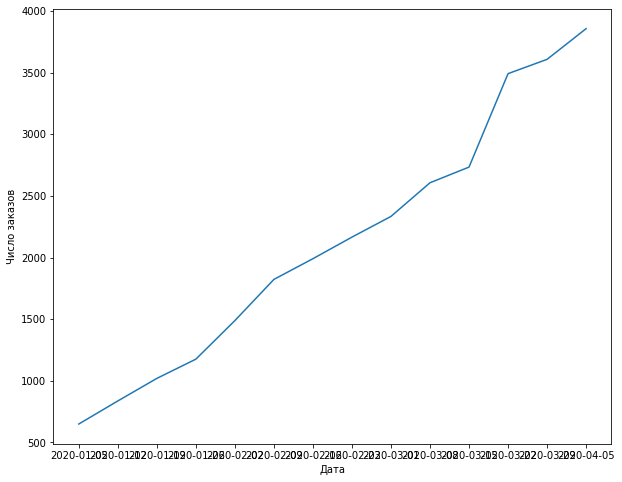

In [6]:
plt.figure(figsize=(10,8))
sns.lineplot(data = df, x='Дата', y='Число заказов')

Исходный датафрейм является слишком маленьким для точного предсказания, но можно попробовать спрогнозировать приблизительный тренд развития с помощью Facebook Prophet. Для этого необходимо привести исходный датафрейм к определенному виду.

### Подготовка датафрейма для Facebook Prophet

Преобразуем названия колонок в стандартизированные. Из функции выше видно, что колонка **'Дата'** имеет тип данных **object**. Её также необходимо привести к виду **datetime**:

In [7]:
df = df.rename(columns={'Дата':'ds', 'Число заказов':'y'})
df['ds'] = pd.to_datetime(df.ds)

### Подготовка модели Facebook Prophet

Поскольку у нас имеется всего 14 строк с данными, не вижу смысла тренировать модель на выборке из них. Будем использовать весь датафрейм. У нас нет необходимой разбивки данных по часам, дням или месяцам, поэтому передать сезонность в параметры модели не представляется возможным. А так как количество наблюдений захватывает лишь малый период от года, то включать праздничные и выходные дни тоже нецелесообразно. 
Учтем проведенную промоакцию **с 02-02-2020 по 09-02-2020**, увеличившую количество заказов на **7%**. Учитывая разбивку данных по неделям, возьмем за итоговую дату события последний ее день **09-02-2020**. Для этого заведем отдельный датафрейм, в который передадим стандартизированное значение промо-акции:

In [8]:
promo_action = pd.DataFrame({'holiday':'promo_action', 'ds':pd.to_datetime(['2020-02-09'])})

In [9]:
promo_action

,holiday,ds
0,promo_action,2020-02-09


In [10]:
predict_model = Prophet(holidays=promo_action)
predict_model.fit(df)
predictions=13

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.



Initial log joint probability = -0.373554
Iteration  1. Log joint probability =    19.3709. Improved by 19.7444.
Iteration  2. Log joint probability =     33.053. Improved by 13.6821.
Iteration  3. Log joint probability =    39.2141. Improved by 6.16112.
Iteration  4. Log joint probability =    39.5556. Improved by 0.341459.
Iteration  5. Log joint probability =    39.7138. Improved by 0.158229.
Iteration  6. Log joint probability =    39.7635. Improved by 0.0496289.
Iteration  7. Log joint probability =    39.9985. Improved by 0.235031.
Iteration  8. Log joint probability =    40.0134. Improved by 0.0149615.
Iteration  9. Log joint probability =    40.0188. Improved by 0.00540398.
Iteration 10. Log joint probability =    40.1875. Improved by 0.168652.
Iteration 11. Log joint probability =    40.2522. Improved by 0.0647232.
Iteration 12. Log joint probability =    40.2799. Improved by 0.0276926.
Iteration 13. Log joint probability =    40.2866. Improved by 0.00669751.
Iteration 14. Lo

In [11]:
future = predict_model.make_future_dataframe(periods=predictions, freq='W')
forecast = predict_model.predict(future)

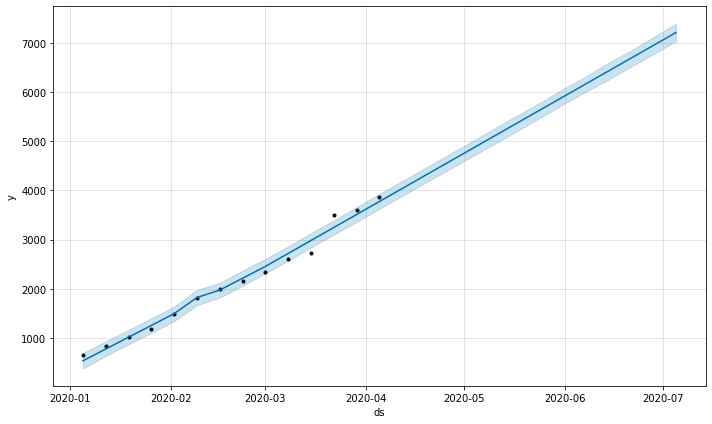

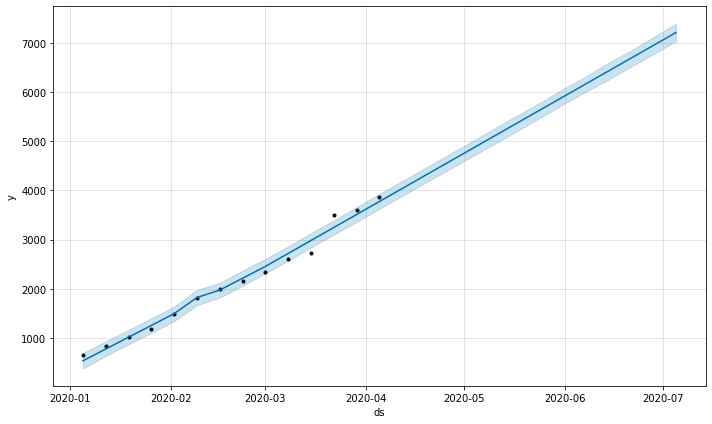

In [12]:
predict_model.plot(forecast)

### Построение интерактивного графика

In [13]:
iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

### Расчет средней ошибки модели предсказания

In [14]:

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[:-predictions]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[:-predictions]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  4.701271565783562 %
MAE (средняя абсолютная ошибка) –  88.21061496642803


### Необходимые значения предсказаний на ближайшие 3 месяца

In [15]:
forecast[['ds', 'trend', 'yhat_lower','yhat_upper']][14:]

,ds,trend,yhat_lower,yhat_upper
14,2020-04-12,4039.462705,3888.395201,4193.831003
15,2020-04-19,4303.569412,4154.159549,4454.704680
16,2020-04-26,4567.676118,4411.644331,4715.713003
17,2020-05-03,4831.782825,4674.216706,4982.159937
18,2020-05-10,5095.889531,4936.412379,5248.177948
19,2020-05-17,5359.996238,5198.557688,5515.166222
20,2020-05-24,5624.102945,5464.881837,5773.039662
21,2020-05-31,5888.209651,5735.099696,6048.915977
22,2020-06-07,6152.316358,5993.252938,6304.394752
23,2020-06-14,6416.423064,6241.683759,6584.086152


## Выводы

* Наблюдается линейный восходящий тренд продаж товара;
* Проведенная акция не сильно повлияла на скорость восхождения линейного тренда;
* Зависимость тренда от сезонности остается неизвестной, необходимо собрать данные за год;
* Необходимо более точно изучить с чем связан рост количества заказов после 22 марта. При таком маленьком количестве данных, он сильно влияет на тренд. 
